In [1]:
import numpy as np
import random
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import time

In [2]:
def digit_counter(sequence, context): 
  count_0 = np.count_nonzero(sequence == context[0])
  count_1 = np.count_nonzero(sequence == context[1])
  if count_0 > count_1: 
    return 0
  elif count_1 > count_0: 
    return 1 
  else: 
    return 0.5


def one_hotify(digit): 
  return np.eye(10)[digit]

In [3]:
def gen_seq( size = 1000, seq_size = 25): 

  for _ in range(size): 
    seq = np.array(0)

    sequence = np.zeros((seq_size,30))
    results = np.zeros((seq_size , 1))


    for i in range(seq_size -1): 
      element = np.random.randint(0,9)
      seq = np.append(sequence, element)

      context = random.sample(range(0,10),2)
      results[i+1,:] = digit_counter(sequence, context)
      sequence[i+1,:] = np.array([one_hotify(context[0]), one_hotify(context[1]), one_hotify(element)]).reshape(-1)
      

    yield sequence, results

In [4]:
train_data = tf.data.Dataset.from_generator(gen_seq, (tf.float32, tf.float32), args = [1000, 25])
test_data = tf.data.Dataset.from_generator(gen_seq, (tf.float32, tf.float32), args = [100, 25])

In [5]:
# batch_size = 64
buffer_size = 60000

In [6]:
# lstm cell 


class lstm_cell(tf.keras.layers.Layer): 

  # hat nicht funktioniert, wenn LT_Size =/= ST_Size
  def __init__(self, LT_Size = 100, ST_Size = 100): 
    super().__init__()


    # layers for forget gate
    self.dense_forget = layers.Dense(units = LT_Size, activation = 'sigmoid', input_shape = (1,100))
  
    # layers for input gate
    self.dense_input = layers.Dense(units = LT_Size, activation = 'sigmoid')

    # cell state candidates 
    self.dense_cell_state = layers.Dense(units = LT_Size, activation = 'tanh')

    # cell state candidates 
    self.dense_output = layers.Dense(units = LT_Size, activation = 'sigmoid')



  def call(self, input, hidden_state, cell_state): 

    # input = tf.expand_dims(input, 1)
    # input = tf.expand_dims(tf.concat([hidden_state,input], 1),1)
    input = tf.concat([hidden_state,input], 1)

    # print("input: ", input.shape) 

    f_t = self.dense_forget(input)
     # print("f_t: ", f_t.shape)



    i_t = self.dense_input(input)
    # print("i_t: ", i_t.shape)

    candidates = self.dense_cell_state(input)
    # print("candidates: ", candidates.shape)

    cell_state = tf.math.multiply(f_t, cell_state) + tf.math.multiply(i_t, candidates)

    o_t = self.dense_output(input)

    hidden_state = tf.math.multiply(o_t, tf.keras.activations.tanh(cell_state))

    return hidden_state, cell_state




In [7]:
#model
class rnn_model(tf.keras.Model):   
  
  def __init__(self, LT_Size = 100, ST_Size = 100, ): 
    super().__init__()

    self.read_in = layers.Dense(30, activation = 'sigmoid', input_shape = (26, 30))    
    self.lstm_cell = lstm_cell()
    self.lstm_cell_2 = lstm_cell()

    self.flatten = layers.Flatten(), 
    self.dense = layers.Dense(1)

    # Memory states


    self.cell_state = tf.zeros((1, LT_Size))
    self.hidden_state = tf.zeros((1 ,ST_Size))
    self.cell_state_2 = tf.zeros((1, LT_Size))
    self.hidden_state_2 = tf.zeros((1 ,ST_Size))

  def call(self, input, seq_len = 25): 

    input = self.read_in(input)

    outputs = []

    # unroll 
    for t in tf.range(seq_len):

      time_stemp = tf.expand_dims(input[t,:], 0) 
      # print(time_stemp.shape)
      self.hidden_state, self.cell_state = self.lstm_cell(time_stemp, self.hidden_state, self.cell_state)
      #outputs.append(tf.reshape(self.hidden_state,[-1]))

      self.hidden_state_2, self.cell_state_2 = self.lstm_cell_2(self.hidden_state, self.hidden_state_2, self.cell_state_2)
      outputs.append(tf.reshape(self.hidden_state_2,[-1]))

    x = tf.convert_to_tensor(outputs)
    #x = self.flatten(x)
    # print(x.shape)
    x = self.dense(x)

    return x 

In [8]:
model = rnn_model()

In [9]:

def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(abs(target - prediction)) < 0.5
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


In [10]:
# %%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 5
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = rnn_model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_data, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:
        train_loss = train_step(model, input, target, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4


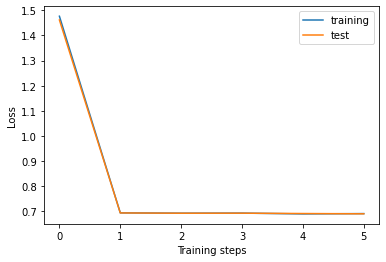

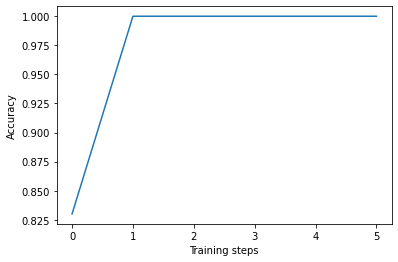

In [11]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [12]:
model.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  930       
_________________________________________________________________
lstm_cell (lstm_cell)        multiple                  52400     
_________________________________________________________________
lstm_cell_1 (lstm_cell)      multiple                  80400     
_________________________________________________________________


ValueError: ignored